In [266]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [267]:
#datasets
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'

#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [268]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scales, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scales])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scales], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    var_names = data_trunc.filter(regex=all_vars).columns
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}, var_names

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    return {'X':X, 'y':y}
    

In [269]:
feature_cols = ['CT', 'L_HC_VOL','R_HC_VOL']
clinical_scale = ['ADAS11', 'ADAS13', 'MMSE']

cv_data, var_names = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
test_data = load_test_data(test_file, clinical_scale, feature_cols)
print cv_data['X_train'][0].shape
print cv_data['y_train'][0].shape

(522, 76)
(522, 3)


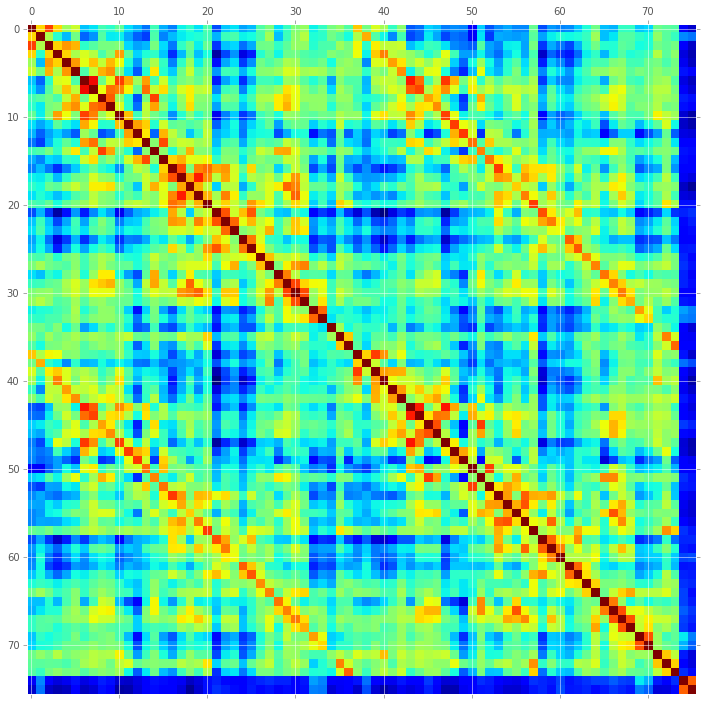

In [270]:
# Correlation matrix
data = pd.read_pickle(train_val_file)
all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
data_trunc = data.filter(regex =all_vars)
data_trunc = data_trunc.dropna(how='any')

plt.matshow(data_trunc.corr())




In [271]:
from sklearn.metrics import mean_squared_error

# Define a feature selection model:
# Multitask lasso

import scipy
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.svm import SVR
BaseSel = linear_model.MultiTaskLasso
    
class Selection(BaseSel):
    def __init__(self, alpha=0.1, normalize=False, fit_intercept=True):
        super(Selection, self).__init__(alpha=alpha, normalize=normalize, fit_intercept=fit_intercept)
    

    def fit(self, X, Y):
        self = super(Selection, self).fit(X,Y)
        df = X.shape[0] - X.shape[1] - 1
        Y_hat = self.predict(X)
        sse = np.sum(np.square(Y - Y_hat), axis=0)
        self.variance_Y = sse/df
        self.variance_X = (np.matrix(X).T * np.matrix(X)).I    
        
        self.zscores_ = self.coef_ / np.sqrt(self.variance_Y.reshape(-1,1) * self.variance_X.diagonal())
        self.pvals_ = 1 - scipy.stats.t.cdf(abs(self.zscores_), df)
    
    def score(self, X, Y):
        N, P = X.shape
        Y_hat = self.predict(X)
        score = super(Selection, self).score(X, Y)
        
        # R2 and adjusted R2:
        self.R2 = np.array([r2_score(Y[:,i], Y_hat[:,i]) for i in range(Y.shape[1])])
        self.rmse = np.array([np.sqrt(mean_squared_error(Y[:,i], Y_hat[:,i])) for i in range(Y.shape[1])])
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_Y = np.var(Y, axis=0)
        Y_bar = np.mean(Y,axis=0)
        
        self.ssm = np.sum(np.square(Y_hat - Y_bar))
        self.sse = np.sum(np.square(Y - Y_hat))
        self.sst = np.sum(np.square(Y - Y_bar))
        self.r = np.array([scipy.stats.pearsonr(Y[:,i], Y_hat[:,i]) for i in range(Y.shape[1])])
        
        return score
    
    def transform(self, X):
        self.supports = np.nonzero(self.coef_[0,:])[0]
        return X[:, self.supports]
        

if BaseSel==linear_model.MultiTaskLasso:
    sel = Selection(alpha=0.1, normalize=False, fit_intercept=True)
else:
    sel = Selection(normalize=False, fit_intercept=True)

In [272]:
from sklearn.metrics import mean_squared_error

# Define a regression model:
# SVRegression

import scipy
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.svm import SVR
BaseReg = SVR
    
class SVRegression(BaseReg):
    def __init__(self, kernel='linear', C=0.1, epsilon=0.1):
        super(SVRegression, self).__init__(kernel=kernel, C=C, epsilon=epsilon)
    

    def fit(self, X, y):
        self = super(SVRegression, self).fit(X,y)
        df = X.shape[0] - X.shape[1] - 1
        y_hat = self.predict(X)
        sse = np.sum(np.square(y - y_hat), axis=0)
        self.variance_y = sse/df
    
    def score(self, X, y):
        N, P = X.shape
        y_hat = self.predict(X)
        
        # R2 and adjusted R2:
        self.R2 = r2_score(y, y_hat)
        self.rmse = np.sqrt(mean_squared_error(y, y_hat))
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_y = np.var(y)
        
        self.ssm = np.sum(np.square(y_hat - y.mean()))
        self.sse = np.sum(np.square(y - y_hat))
        self.sst = np.sum(np.square(y - y.mean()))
        self.r = scipy.stats.pearsonr(y, y_hat)
        
        return self.R2
        
reg = SVRegression()

In [273]:
X = cv_data['X_train'][0]
Y = cv_data['y_train'][0]
X_v = cv_data['X_valid'][0]
Y_v = cv_data['y_valid'][0]
N, P = X.shape
print Y_v.shape
reg.fit(X,Y[:,0])
print reg.kernel
print reg.score(X_v, Y_v[:,0])
print reg.R2
print reg.adj_R2
print reg.r
print reg.rmse

(59, 3)
linear
0.290005927889
0.290005927889
3.12998221633
(0.55529364331866871, 5.0015212266998449e-06)
5.37594534041


In [274]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RandomizedLasso

# Cross-validation loop
stats = np.zeros(shape=(3,10,5))
coefs = np.zeros(shape=(3,10,X.shape[1]))
reg_params = np.zeros(shape=(3,10,2))
zscores = []
pvals = []
feat_scores = []
supports = []

for fold in range(len(cv_data['X_train'])):
    print
    print 'outer fold {}'.format(fold),
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold]
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold]
        
    sel_pipeline = Pipeline([
        ('selector', Selection()),
    ])
    
    sel_parameters = {
        'selector__alpha': np.logspace(-3,3,15),
        'selector__normalize': [False],
        'selector__fit_intercept': [True],
    }

    grid_search = GridSearchCV(sel_pipeline, param_grid=sel_parameters, n_jobs=-1)
    grid_search.fit(X, y)
    
    cvsel = grid_search.best_estimator_.steps[-1][-1]
    
    X_r = cvsel.transform(X)
    
    reg_stats = []
    # Regression for each scale:
    for i in range(y.shape[1]):
        print '...regressor for {}'.format(clinical_scale[i]),
        reg_pipeline = Pipeline([
            ('regressor', SVRegression()),
        ])
        
        reg_parameters = {
            'regressor__C': np.logspace(-3,3,7),
            'regressor__epsilon': np.logspace(-3,3,7),
            'regressor__kernel': ['linear'],
        }
        reg_grid_search = GridSearchCV(reg_pipeline, param_grid=reg_parameters, n_jobs=-1)
        reg_grid_search.fit(X_r, y[:,i])
        cvreg = reg_grid_search.best_estimator_.steps[-1][-1]
    
        # validation:
        X_v_r = cvsel.transform(X_v)
        y_hat_v = cvreg.predict(X_v_r)
        cvreg.score(X_v_r, y_v[:,i])
        
        # Book keepin':
        best_parameters = reg_grid_search.best_params_
        stats[i, fold, : ] = np.array([cvreg.R2, cvreg.adj_R2, cvreg.rmse, cvreg.r[0], cvreg.r[1]])
        reg_params[i, fold, :] = np.array([best_parameters['regressor__C'], best_parameters['regressor__epsilon']])
        
        coefs[i, fold, cvsel.supports] = cvreg.coef_
print 'done cv'


outer fold 0 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 1 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 2 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 3 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 4 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 5 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 6 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 7 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 8 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE
outer fold 9 ...regressor for ADAS11 ...regressor for ADAS13 ...regressor for MMSE done cv


In [275]:
def make_table(k, var_names, **kwargs):
    header_mean = ['Mean {}'.format(key) for key in kwargs.keys()]
    header_std = ['Std {}'.format(key) for key in kwargs.keys()]
    header = header_mean + header_std
    header[::2]=header_mean
    header[1::2]=header_std
    header = ['Variables'] + header
    table = np.zeros(shape=(len(var_names),2 * len(kwargs.keys())))
    for i, stat in enumerate(kwargs.values()):
        M=stat.reshape(k,-1).T
        table[:, i*2] = np.mean(M,axis=1)
        table[:, (i*2)+1] = np.std(M,axis=1)
    
    frame = pd.DataFrame(table)
    frame.insert(0, 'Variable', var_names)
    frame.columns = header
    return frame

In [276]:
from IPython.display import display
mean_coefs = np.mean(coefs, axis=1).T
best_alpha=scipy.stats.mode(alphas)[0][0]
best_C=scipy.stats.mode(reg_params[:,:,0], axis=1)[0]
best_epsilon=scipy.stats.mode(reg_params[:,:,1], axis=1)[0]

print 'Mode of MT Lasso regularization param: {}'.format(best_alpha)
print 'Modes of SVRegressor penalty parameter of the error term.: {}, {}, {}'.format(best_C[0], best_C[1], best_C[2])
print 'Modes of SVRegressor param epsilon: {}, {}, {}'.format(best_epsilon[0], best_epsilon[1], best_epsilon[2])

for i in range(Y.shape[1]):
    print '{} scale regression:'.format(clinical_scale[i])
    model=make_table(10, ['Model'], R2=stats[i,:,0], Adj_R2=stats[i,:,1], RMSE=stats[i,:,2], r=stats[i,:,3], pval=stats[i,:,4])
    display(model)

Mode of MT Lasso regularization param: 1e-05
Modes of SVRegressor penalty parameter of the error term.: [ 1.], [ 1.], [ 0.1]
Modes of SVRegressor param epsilon: [ 1.], [ 10.], [ 1.]
ADAS11 scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,-0.844916,0.297936,0.001372,0.002092,0.462597,0.075225,0.190403,0.064359,5.354946,0.618695


ADAS13 scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,-0.767291,0.380781,0.000319,0.000609,0.509916,0.064909,0.231391,0.058523,7.705201,0.818084


MMSE scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,-0.903732,0.450265,0.00673,0.013423,0.450854,0.106582,0.174617,0.090028,2.309278,0.167071


(42, 3)
42 Features with non-zero coefficients:


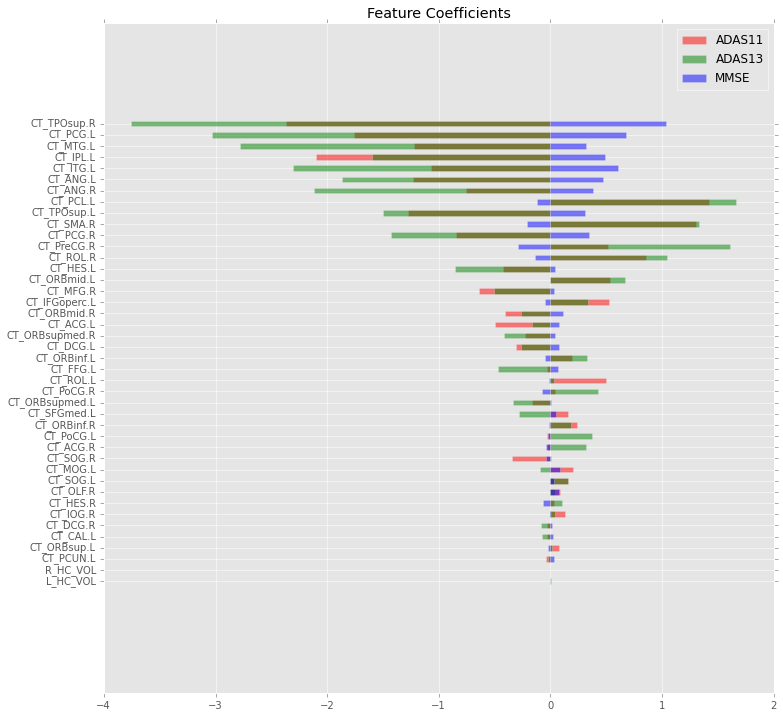

In [277]:
feats = zip(var_names, mean_coefs)
feats.sort(reverse=False, key=lambda x: np.sum(abs(x[1])))
feats = [feat for feat in feats if np.sum(abs(feat[1])) > 0.0]
coef_matrix = np.array(zip(*feats)[1])
print coef_matrix.shape
# Plot the feature importances of the classifier
print '{} Features with non-zero coefficients:'.format(len(feats))
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))

#print [coef for coef in zip(*feats)[1]]

plt.barh(y_pos, width=coef_matrix[:,0], height=0.5, color='r', align="center", alpha=0.5, label='{}'.format(clinical_scale[0]))
plt.barh(y_pos, width=coef_matrix[:,1], height=0.5, color='g', align="center", alpha=0.5, label='{}'.format(clinical_scale[1]))
plt.barh(y_pos, width=coef_matrix[:,2], height=0.5, color='b', align="center", alpha=0.5, label='{}'.format(clinical_scale[2]))
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()

In [278]:
from sklearn.linear_model import Ridge

# Fit final model for testing
X_tv = np.concatenate([cv_data['X_train'][0], cv_data['X_valid'][0]], axis=0)
y_tv = np.concatenate([cv_data['y_train'][0], cv_data['y_valid'][0]], axis=0)

test_sel = Selection(alpha=best_alpha, normalize=False, fit_intercept=True)
test_sel.fit(X_tv, y_tv)
X_tv_r = test_sel.transform(X_tv)

In [279]:
X_t = test_data['X']
y_t = test_data['y']
X_t_r = test_sel.transform(X_t)

test_stats = np.zeros(shape=(y_t.shape[1], 4))
y_hats = np.zeros(shape=(X_t.shape[0], y_t.shape[1]))

for i, scale in enumerate(clinical_scale):
    test_reg = SVRegression(kernel='linear', C=best_C[i][0], epsilon=best_epsilon[i][0])
    test_reg.fit(X_tv_r, y_tv[:,i])
    y_hat_t=test_reg.predict(X_t_r)
    y_hats[:,i] = y_hat_t
    R2 = r2_score(y_t[:,i], y_hat_t)
    r = scipy.stats.pearsonr(y_t[:,i], y_hat_t)
    rmse = np.sqrt(mean_squared_error(y_t[:,i], y_hat_t))
    test_stats[i,:] = np.array([rmse, R2, r[0], r[1]])


,Scale,RMSE,R2,correlation,p-val
0,ADAS11,6.215017,0.082971,0.353025,1.550671e-04
1,ADAS13,8.029061,0.238135,0.490041,5.519231e-08
2,MMSE,2.234912,0.153312,0.428813,2.955358e-06


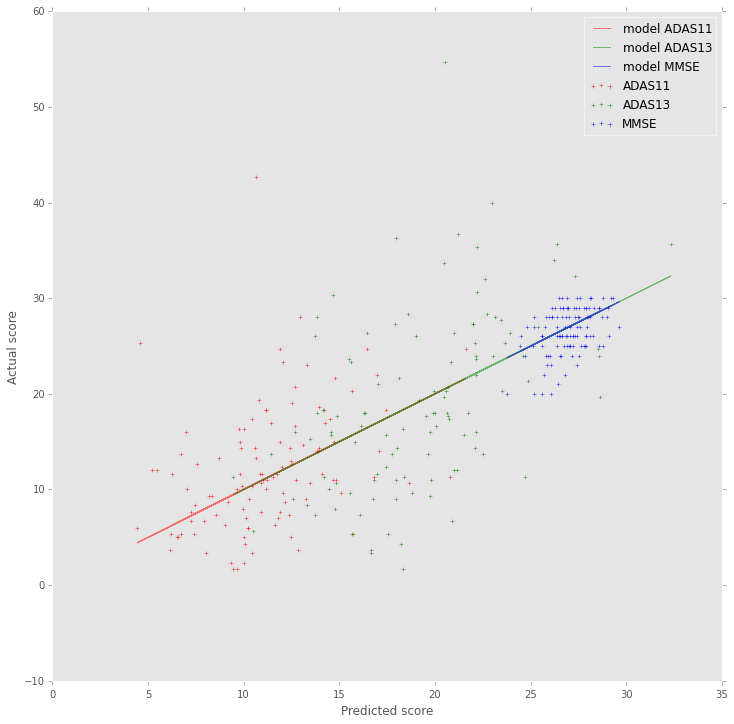

In [280]:
line_col = {0: 'red', 1: 'green', 2: 'blue'}

table = pd.DataFrame(test_stats)
table.insert(0, 'Scale', clinical_scale)
table.columns = ['Scale', 'RMSE', 'R2', 'correlation', 'p-val']
display(table)
for i, scale in enumerate(clinical_scale):
    ax=plt.subplot(1,1,1)
    plt.scatter(y_hats[:,i], y_t[:,i], marker='+', color=line_col[i], alpha=.75, label='{}'.format(scale))
    plt.plot(y_hats[:,i], y_hats[:,i], color=line_col[i], linewidth=1, alpha=0.5, label='model {}'.format(scale))
plt.legend()
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
plt.grid()    
plt.show()